# Minimal Q-Learning in a 5×5 GridWorld (4 actions)



In [1]:
# Import Required Libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# Constants and Hyperparameters
N_ROWS, N_COLS = 25, 25
START = (0, 24)
GOAL = (24, 24)
WALLS = [
    # Original walls
    (2, 2), (3, 4), (5, 1), (7, 3), (4, 6), (8, 2), (6, 7),
    (2, 15), (4, 18), (6, 12), (8, 20), (3, 22), (7, 16), (9, 14),
    (15, 2), (18, 5), (20, 1), (16, 7), (22, 4), (19, 8), (17, 3),
    (15, 18), (17, 21), (19, 16), (21, 19), (18, 23), (16, 15), (20, 17),
    (10, 10), (12, 8), (14, 12), (11, 15), (13, 6), (9, 18), (15, 9),
    (5, 11), (8, 16), (11, 3), (14, 20), (17, 6), (20, 13), (23, 8),
    (1, 9), (4, 14), (7, 19), (10, 22), (13, 17), (16, 11), (19, 2),
    (22, 15), (6, 5), (9, 8), (12, 18), (15, 4), (18, 14), (21, 7),
    (1, 23), (23, 1), (24, 21), (21, 24),
     # Additional strategic walls to make diagonal actions useful
    # Vertical barriers that force diagonal movement
    (5, 5), (6, 5), (7, 5), (8, 5), (9, 5),  # Vertical wall forcing diagonal detour
    (5, 19), (6, 19), (7, 19), (8, 19), (9, 19),  # Another vertical barrier
    
    # Horizontal barriers
    (12, 12), (12, 13), (12, 14), (12, 15), (12, 16),  # Horizontal wall
    (18, 8), (18, 9), (18, 10), (18, 11), (18, 12),  # Another horizontal barrier
    
    # L-shaped barriers that encourage diagonal shortcuts
    (10, 5), (11, 5), (12, 5), (10, 6), (10, 7),  # L-shape 1
    (14, 18), (14, 19), (14, 20), (15, 20), (16, 20),  # L-shape 2
    
    # Staircase patterns where diagonal is clearly better
    (3, 8), (4, 9), (5, 10), (6, 11), (7, 12),  # Staircase 1
    (18, 2), (19, 3), (20, 4), (21, 5), (22, 6),  # Staircase 2
    
    # Cross patterns creating diagonal corridors
    (13, 10), (13, 11), (13, 12), (12, 11), (14, 11),  # Cross 1
    (8, 8), (8, 9), (8, 10), (7, 9), (9, 9),  # Cross 2
    
    # Maze-like sections where diagonal movement is advantageous
    (1, 12), (2, 12), (3, 12), (1, 14), (3, 14),  # Maze section 1
    (20, 20), (21, 20), (22, 20), (20, 22), (22, 22),  # Maze section 2
    
    # Additional scattered obstacles to increase complexity
    (11, 1), (13, 2), (15, 3), (17, 4), (19, 5),  # Diagonal line of obstacles
    (4, 21), (6, 20), (8, 19), (10, 18), (12, 17),  # Another diagonal line
    
    # STRATEGIC WALLS FOR DIAGONAL Q-VALUE IMPROVEMENT
    
    # 1. Diagonal Corridors - Force diagonal movement for optimal paths
    # Create narrow diagonal passages where diagonal actions are the only efficient way
    (1, 4), (2, 5), (3, 6), (1, 6), (3, 4),  # Diagonal corridor 1 (forces SE/NW movement)
    (21, 3), (20, 4), (19, 5), (21, 5), (19, 3),  # Diagonal corridor 2 (forces SW/NE movement)
    
    # 2. Zig-zag barriers that make diagonal shortcuts extremely valuable
    (5, 13), (6, 14), (7, 13), (8, 14), (9, 13), (10, 14),  # Zig-zag forcing diagonal cuts
    (15, 6), (16, 7), (17, 6), (18, 7), (19, 6), (20, 7),   # Another zig-zag pattern
    
    # 3. Box mazes with diagonal escapes
    # Create box-like structures where diagonal movement provides escape routes
    (4, 4), (4, 5), (4, 6), (5, 4), (6, 4), (6, 6),  # Box with diagonal escape at (5,5)
    (20, 18), (20, 19), (20, 20), (21, 18), (22, 18), (22, 20),  # Box with diagonal escape
    
    # 4. Diamond-shaped obstacles that reward diagonal navigation
    (9, 3), (8, 4), (10, 4), (7, 5), (11, 5), (8, 6), (10, 6), (9, 7),  # Diamond 1
    (16, 13), (15, 14), (17, 14), (14, 15), (18, 15), (15, 16), (17, 16), (16, 17),  # Diamond 2
    
    # 5. Bottleneck passages that force diagonal thinking
    # Create narrow passages where diagonal movement is the key to efficiency
    (11, 9), (11, 10), (11, 11), (11, 12), (11, 13),  # Vertical bottleneck
    (13, 9), (14, 9), (15, 9), (16, 9), (17, 9),      # Horizontal bottleneck
    # Only diagonal paths can efficiently navigate around these
    
    # 6. Spiral-like patterns where diagonal cuts are optimal
    (2, 7), (3, 7), (4, 7), (4, 8), (4, 9), (3, 9), (2, 9), (2, 8),  # Spiral 1
    (22, 13), (21, 13), (20, 13), (20, 14), (20, 15), (21, 15), (22, 15), (22, 14),  # Spiral 2
    
    # 7. Alternating barriers creating diagonal "lanes"
    (6, 1), (7, 2), (6, 3), (7, 4), (6, 5),  # Alternating pattern 1
    (18, 21), (19, 20), (18, 19), (19, 18), (18, 17),  # Alternating pattern 2
    
    # 8. Strategic corner blocks that make diagonal movement essential
    # Place walls that block cardinal paths but leave diagonal paths open
    (1, 1), (1, 2), (2, 1),  # Corner block forcing diagonal start
    (23, 22), (23, 23), (22, 23),  # Corner block near goal requiring diagonal approach
    
    # 9. Checker-board pattern sections
    (14, 2), (16, 2), (14, 4), (16, 4),  # Checkerboard forcing diagonal weaving
    (8, 21), (10, 21), (8, 23), (10, 23),  # Another checkerboard section
    
    # 10. Long diagonal barriers that create "diagonal highways"
    (5, 7), (6, 8), (7, 9), (8, 10), (9, 11),  # Diagonal highway 1
    (19, 9), (18, 10), (17, 11), (16, 12), (15, 13),  # Diagonal highway 2
    
    # Border reinforcements to prevent edge shortcuts
    (1, 12), (2, 12), (23, 12), (24, 12),  # Middle column obstacles
    (12, 1), (12, 2), (12, 23), (12, 24),  # Middle row obstacles    
]
STEP_REWARD = -0.1
BUMP_REWARD = -0.1
GOAL_REWARD = 1.0
GAMMA = 0.95
ALPHA = 0.5
EPISODES = 600
EPS_START, EPS_END, EPS_DECAY_EPISODES = 1.0, 0.05, 300
MAX_STEPS = 200
SEED = 123

In [2]:
class GridWorld:
    def __init__(self, n_rows, n_cols, start, goal, walls, step_reward, goal_reward, gamma):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.start = start
        self.goal = goal
        self.walls = set(walls)
        self.step_reward = step_reward
        self.goal_reward = goal_reward
        self.gamma = gamma

    def in_bounds(self, state):
        r, c = state
        return 0 <= r < self.n_rows and 0 <= c < self.n_cols

    def step(self, state, action, actions):
        if state == self.goal:
            return state, 0.0, True
        dr, dc = actions[action]
        next_state = (state[0] + dr, state[1] + dc)
        if not self.in_bounds(next_state) or next_state in self.walls:
            next_state = state  # Stay put if invalid
        reward = self.goal_reward if next_state == self.goal else self.step_reward
        done = next_state == self.goal
        return next_state, reward, done

    def to_index(self, state):
        r, c = state
        return r * self.n_cols + c

    def from_index(self, index):
        r = index // self.n_cols
        c = index % self.n_cols
        return (r, c)

# Initialize the GridWorld environment
grid_world = GridWorld(
    n_rows=25,
    n_cols=25,
    start=(0, 0),
    goal=(24, 24),
    walls = WALLS,
    step_reward=-0.1,
    goal_reward=1.0,
    gamma=0.95
)

All required functions:

In [3]:
# Action definitions
ACTIONS_4 = {
    0: (-1, 0),  # Up
    1: ( 1, 0),  # Down
    2: ( 0,-1),  # Left
    3: ( 0, 1),  # Right
}

ACTIONS_5 = dict(ACTIONS_4)
ACTIONS_5[4] = (1, 1)  # south-east (down-right)

# Utility functions
def epsilon_greedy(q_row, epsilon, rng):
    """Epsilon-greedy action selection"""
    if rng.random() < epsilon:
        return int(rng.integers(len(q_row)))
    # break ties randomly among maxima
    max_q = np.max(q_row)
    best = np.flatnonzero(q_row == max_q)
    return int(rng.choice(best))

def moving_average(x, w=20):
    """Calculate moving average"""
    if len(x) < w:
        return x.copy()
    return np.convolve(x, np.ones(w)/w, mode='valid')

# Legacy function wrappers for compatibility
def to_index(s):
    return grid_world.to_index(s)

def from_index(i):
    return grid_world.from_index(i)

def step(s, a, actions):
    return grid_world.step(s, a, actions)

More functions for visualisation:

In [4]:
class Visualizer:
    ARROWS = {0: '↑', 1: '↓', 2: '←', 3: '→', 4: '↘'}

    @staticmethod
    def derive_policy(Q, n_rows, n_cols):
        return np.argmax(Q, axis=1).reshape(n_rows, n_cols)

    @staticmethod
    def render_policy(policy, n_rows, n_cols, walls, start, goal):
        grid = []
        for r in range(n_rows):
            row = []
            for c in range(n_cols):
                s = (r, c)
                if s in walls:
                    row.append('■')
                elif s == goal:
                    row.append('G')
                elif s == start:
                    row.append('S')
                else:
                    row.append(Visualizer.ARROWS[int(policy[r, c])])
            grid.append(' '.join(row))
        print('\nOptimal policy (arrows), S=start, G=goal, ■=wall')
        print('\n'.join(grid))

    @staticmethod
    def print_value_grid(Q, n_rows, n_cols):
        V = np.max(Q, axis=1).reshape(n_rows, n_cols)
        with np.printoptions(precision=2, suppress=True):
            print('\nState-value grid V(s)=max_a Q(s,a):')
            print(V)

    @staticmethod
    def plot_results(returns, bumps, ma_window, label_prefix):
        ret_ma = np.convolve(returns, np.ones(ma_window)/ma_window, mode='valid')
        bumps_ma = np.convolve(bumps, np.ones(ma_window)/ma_window, mode='valid')

        plt.figure(figsize=(7.5, 4.2))
        plt.plot(np.arange(len(returns))[-len(ret_ma):], ret_ma, label=f'Return: {label_prefix}')
        plt.xlabel('Episode')
        plt.ylabel('Discounted return')
        plt.title('Q-learning in GridWorld')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(7.5, 4.2))
        plt.plot(bumps_ma, label=f'Total bumps: {label_prefix}')
        plt.xlabel('Episode')
        plt.ylabel('Total Bumps')
        plt.title('Q-learning in GridWorld')
        plt.legend()
        plt.tight_layout()
        plt.show()

## **1. Q learning with 4 actions:**

In [5]:
# Q-learning with 4 actions using refactored approach
rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)

NUM_STATES = N_ROWS * N_COLS
NUM_ACTIONS_4 = 4
Q4 = np.zeros((NUM_STATES, NUM_ACTIONS_4), dtype=float)

returns = np.zeros(EPISODES, dtype=float)
bumps = np.zeros(EPISODES, dtype=float)
steps_arr = np.zeros(EPISODES, dtype=int)

eps = EPS_START
eps_decay = (EPS_START - EPS_END) / max(1, EPS_DECAY_EPISODES)

for ep in range(EPISODES):
    s = START
    si = grid_world.to_index(s)
    done = False
    G = 0.0
    bumpcount = 0
    disc = 1.0
    steps = 0

    for t in range(MAX_STEPS):
        a = epsilon_greedy(Q4[si], eps, rng)
        s_next, r, done = grid_world.step(s, a, ACTIONS_4)
        s_next_i = grid_world.to_index(s_next)

        if si == s_next_i:
            bumpcount += 1
            r = BUMP_REWARD

        target = r if done else r + GAMMA * np.max(Q4[s_next_i])
        Q4[si, a] += ALPHA * (target - Q4[si, a])

        G += r
        disc *= GAMMA
        s, si = s_next, s_next_i
        steps += 1
        if done:
            break

    returns[ep] = G
    bumps[ep] = bumpcount
    steps_arr[ep] = steps
    if ep < EPS_DECAY_EPISODES:
        eps = max(EPS_END, eps - eps_decay)

print('Training (4 actions) complete!')
returns4 = returns.copy()
bumps4 = bumps.copy()
ma_w = 25
ret_ma4 = moving_average(returns4, w=ma_w)

policy4 = Visualizer.derive_policy(Q4, N_ROWS, N_COLS)
Visualizer.render_policy(policy4, N_ROWS, N_COLS, WALLS, START, GOAL)
Visualizer.print_value_grid(Q4, N_ROWS, N_COLS)

Training (4 actions) complete!

Optimal policy (arrows), S=start, G=goal, ■=wall
↓ ↓ ← ← ← ← ← → ← ← ← ← ↑ ← ← ← ↓ ↑ ← ← ↓ ← ↑ ↑ S
↓ ■ ■ ← ■ → ■ ↓ ← ■ ↑ ↓ ■ ← ■ ↓ ↑ ↑ ↓ ← ← ↓ ← ■ ↓
← ■ ■ ↓ ↑ ■ ↑ ■ ■ ■ ↑ ↓ ■ → ↓ ■ → ← → ↑ ↓ ← ↓ ← →
↑ → ← ← ■ ↑ ■ ■ ■ ■ ↓ ← ■ ← ■ ← ← ↑ ← ↓ ← ↓ ■ ↓ ←
→ ↑ ↓ → ■ ■ ■ ■ ■ ■ ↓ → → ↓ ■ ↑ ← → ■ ↓ ← ■ ↓ ← →
→ ■ ↓ ↓ ■ ■ ↑ ■ ↑ ↑ ■ ■ ← ■ ← ↓ ↓ → → ■ ↑ ↑ ↑ ↓ ↑
↓ ■ → ■ ■ ■ ■ ■ ■ ↑ ↑ ■ ■ ↑ ■ ↓ ← ↑ → ■ ■ → ← ← →
→ ↓ ■ ■ ■ ■ ↑ ↑ ↑ ■ ↑ ↑ ■ ■ ← ↑ ■ → ← ■ ↓ ↓ → ← ↓
→ → ■ ↑ ■ ■ ■ ↑ ■ ■ ■ ↑ ↑ ↑ ■ ↑ ■ ↑ ↑ ■ ■ ■ ↓ ■ ←
→ ← ↑ ■ ↑ ■ ↑ ■ ■ ■ ↑ ■ ↑ ■ ■ ↓ ← ↑ ■ ■ ← → ↑ ↑ ↓
↓ ← ↓ ↓ ■ ■ ■ ■ ↑ ↑ ■ ↑ ↑ ↑ ■ ↑ ↓ ← ■ ← ← ■ ■ ■ →
↓ ■ ↓ ■ ↑ ■ ↑ ↑ ↑ ■ ■ ■ ■ ■ ↑ ■ → ↑ ← ↑ ↑ → ↓ ↑ ↑
← ■ ■ ↑ ↑ ■ ↑ ↑ ■ ↑ ↑ ■ ■ ■ ■ ■ ■ ■ ■ ↓ ↓ → → ■ ■
↓ ↑ ■ ↑ ↑ ↑ ■ ↑ ↑ ■ ■ ■ ■ ↑ ↑ ↑ ↑ ■ ↓ ← ← ← ↓ ↓ ↑
→ ← ■ ↑ ■ ↑ ↑ ↑ ↑ ■ ↑ ■ ■ ↑ ↑ ■ ↑ ↑ ■ ■ ■ ↓ ↑ ↓ ←
↓ ↓ ■ ■ ■ ↑ ■ ↑ ↑ ■ ↑ ↑ ↑ ■ ■ ↑ ■ ↑ ■ ↑ ■ ← ↓ ↓ →
↓ ↓ ■ ↑ ■ ↑ ↑ ■ ↑ ■ ↑ ■ ■ ■ ↑ ■ ↑ ■ ↑ ↑ ■ ← ← ↓ →
← ↓ ↑ ■ ■ ↑ ■ ↑ ↑ ■ ↑ ■ ↓ → ■ ↑ ■ ↑ ↑ ↑ ↑ ■ → ↑ →
→ ← ■ ↑ ↑ ■ ↑ ■ ■ ■

## **2. Plain Q learning with 5 actions:**

In [6]:
class QLearningAgent:
    def __init__(self, grid_world, n_actions, episodes=600, alpha=0.5, 
                 eps_start=1.0, eps_end=0.05, eps_decay_episodes=300, 
                 max_steps=200, seed=123):
        self.grid_world = grid_world
        self.n_actions = n_actions
        self.episodes = episodes
        self.alpha = alpha
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay_episodes = eps_decay_episodes
        self.max_steps = max_steps
        self.seed = seed
        
        # Initialize random number generators
        self.rng = np.random.default_rng(seed)
        random.seed(seed)
        np.random.seed(seed)
        
        # Initialize Q-table and tracking arrays
        self.num_states = grid_world.n_rows * grid_world.n_cols
        self.Q = np.zeros((self.num_states, n_actions), dtype=float)
        self.returns = np.zeros(episodes, dtype=float)
        self.bumps = np.zeros(episodes, dtype=float)
        self.steps_arr = np.zeros(episodes, dtype=int)
        
        # Epsilon decay calculation
        self.eps_decay = (eps_start - eps_end) / max(1, eps_decay_episodes)
    
    def train(self, actions_dict, epsilon_greedy_func, bump_reward):
        """Train the Q-learning agent"""
        eps = self.eps_start
        
        for ep in range(self.episodes):
            s = self.grid_world.start
            si = self.grid_world.to_index(s)
            done = False
            G = 0.0
            bumpcount = 0
            disc = 1.0
            steps = 0

            for t in range(self.max_steps):
                a = epsilon_greedy_func(self.Q[si], eps, self.rng)
                s_next, r, done = self.grid_world.step(s, a, actions_dict)
                s_next_i = self.grid_world.to_index(s_next)

                if si == s_next_i:
                    bumpcount += 1
                    r = bump_reward

                target = r if done else r + self.grid_world.gamma * np.max(self.Q[s_next_i])
                self.Q[si, a] += self.alpha * (target - self.Q[si, a])

                G += r
                disc *= self.grid_world.gamma
                s, si = s_next, s_next_i
                steps += 1
                if done:
                    break

            self.returns[ep] = G
            self.bumps[ep] = bumpcount
            self.steps_arr[ep] = steps
            
            if ep < self.eps_decay_episodes:
                eps = max(self.eps_end, eps - self.eps_decay)
        
        print(f'Training ({self.n_actions} actions) complete!')
    
    def get_policy(self, n_rows, n_cols):
        """Get the derived policy from Q-table"""
        return Visualizer.derive_policy(self.Q, n_rows, n_cols)
    
    def get_results(self, moving_average_func, ma_window=25):
        """Get training results with moving averages"""
        return {
            'returns': self.returns.copy(),
            'Q': self.Q.copy(),
            'bumps': self.bumps.copy(),
            'returns_ma': moving_average_func(self.returns, w=ma_window),
            'steps_ma': moving_average_func(self.steps_arr.astype(float), w=ma_window)
        }

# Usage example for plain Q-learning with 5 actions:
agent = QLearningAgent(grid_world, 5, seed=SEED)
agent.train(ACTIONS_5, epsilon_greedy, BUMP_REWARD)

policy5plain = agent.get_policy(N_ROWS, N_COLS)
Visualizer.render_policy(policy5plain, N_ROWS, N_COLS, WALLS, START, GOAL)
Visualizer.print_value_grid(agent.Q, N_ROWS, N_COLS)

results = agent.get_results(moving_average)
returns5plain = results['returns']
Q5plain = results['Q']
bumps5plain = results['bumps']
ret_ma5plain = results['returns_ma']
steps_m5plain = results['steps_ma']

Training (5 actions) complete!

Optimal policy (arrows), S=start, G=goal, ■=wall
→ → → → → → → → → ↘ → → ↑ ↓ → ↑ ↑ ↓ ↓ ↘ → ↓ ↓ ↑ S
↘ ■ ■ ↑ ■ ↑ ■ ↑ ↑ ■ ↓ ↓ ■ ↓ ■ ↑ ↘ → ↑ ↑ ↑ ← ← ■ →
← ■ ■ ↓ ↑ ■ ↘ ■ ■ ■ ↘ ↓ ■ ← ← ■ ↓ ↘ ↑ ← → ← → ↓ →
↓ → ↑ ← ■ ↘ ■ ■ ■ ■ ↘ ↘ ■ → ■ ↘ ↑ → → ← → ↑ ■ ↑ ←
↘ ← ↘ ↘ ■ ■ ■ ■ ■ ■ ← ↘ ↓ ↘ ■ ↑ ↓ ↑ ■ → ↑ ■ ↘ ← ↘
↓ ■ ↘ ↘ ■ ■ ↑ ■ ↑ ↑ ■ ■ ↘ ■ ↘ ↑ ↘ ↓ → ■ ↓ ↓ ← ↓ ↘
↓ ■ ↓ ■ ■ ■ ■ ■ ■ ↑ ↑ ■ ■ ↘ ■ ↓ ↘ ↓ ← ■ ■ → ↑ ← ↘
↑ ↑ ■ ■ ■ ■ ↑ ↑ ↑ ■ ↑ ↑ ■ ■ ↘ ↓ ■ ↓ ← ■ ← ↓ ↓ ↓ →
← → ■ ↑ ■ ■ ■ ↑ ■ ■ ■ ↑ ↑ ↑ ■ ↘ ■ ↓ ← ■ ■ ■ ↓ ■ ↘
← ↘ ↓ ■ ↑ ■ ↑ ■ ■ ■ ↑ ■ ↑ ■ ■ → ↘ ↓ ■ ■ ↓ ← ← ← ↘
↓ → ↘ ↑ ■ ■ ■ ■ ← → ■ ↑ ↑ ↑ ■ ← → ↘ ■ ← ↓ ■ ■ ■ ↓
↓ ■ ↘ ■ → ■ ↑ ↑ ← ■ ■ ■ ■ ■ ↑ ■ ↘ → ↘ ↘ ↓ ← ↓ ← ←
↓ ■ ■ ↘ ↓ ■ ← ↑ ■ ↑ ↑ ■ ■ ■ ■ ■ ■ ■ ■ ↘ ↓ ↓ ↓ ■ ■
← → ■ ← ↘ ↓ ■ ↓ ← ■ ■ ■ ■ ↑ ↑ ↑ ↑ ■ ↑ → ↘ ↓ ↘ ↓ ↘
↑ → ■ ↓ ■ ↓ ← ↑ ↑ ■ ↑ ■ ■ ↑ ↑ ■ ↑ ↑ ■ ■ ■ ↓ ↘ ↓ ↘
↑ ↓ ■ ■ ■ ↓ ■ ← ← ■ ↑ ↑ ↑ ■ ■ ↑ ■ ↑ ■ ↑ ■ ↘ ↘ ↓ ↑
↘ ↓ ■ ↑ ■ ↓ ↓ ■ ↘ ■ ↑ ■ ■ ■ ↑ ■ ↑ ■ ↑ ↑ ■ ↘ ↓ ↓ ←
→ → → ■ ■ ↘ ■ ↓ ↓ ■ ↑ ■ ↓ → ■ ↑ ■ ↑ ↑ ↑ ↑ ■ ↓ ← ↓
↑ ← ■ ↘ ↓ ■ ↘ ■ ■ ■

## **3. Q learning with 5 actions and an oracle model**

In [7]:
def oracle_model(s):
    """Oracle model that predicts the next state for action 4 (south-east)"""
    s_model_next, r_model, done_model = grid_world.step(grid_world.from_index(s), 4, ACTIONS_5)
    return s_model_next

In [8]:
class OracleQLearningAgent(QLearningAgent):
    """Q-learning agent with oracle model for action adaptation"""
    
    def __init__(self, grid_world, n_actions, base_q_table=None, episodes=600, alpha=0.5, 
                 eps_start=1.0, eps_end=0.05, eps_decay_episodes=300, 
                 max_steps=200, seed=123, use_model = True, use_conditional = True):
        super().__init__(grid_world, n_actions, episodes, alpha, eps_start, eps_end, 
                        eps_decay_episodes, max_steps, seed)
        self.reuse_count = np.zeros(self.episodes, dtype = float)
        self.use_model = use_model
        self.use_conditional = use_conditional
        # Initialize with base Q-table if provided
        if base_q_table is not None:
            self.Q[:, :base_q_table.shape[1]] = base_q_table
            # Optimistic initialization for new actions
            if use_model == True:
                V_old = np.max(base_q_table, axis=1) 
                for new_action in range(base_q_table.shape[1], n_actions):
                    self.Q[:, new_action] = V_old
    
    def train_with_oracle(self, actions_dict, epsilon_greedy_func, bump_reward, oracle_func, base_q_table):
        """Train with oracle model guidance"""
        eps = self.eps_start
        for ep in range(self.episodes):
            s = self.grid_world.start
            si = self.grid_world.to_index(s)
            done = False
            G = 0.0
            bumpcount = 0
            disc = 1.0
            steps = 0
            reuse = 0
            for t in range(self.max_steps):
                a = epsilon_greedy_func(self.Q[si], eps, self.rng)
                # Oracle guidance for new action (action 4)
                if self.use_conditional is True:
                  if a == 4:
                    snext_model = oracle_func(si)
                    snext_model_i = self.grid_world.to_index(snext_model)
                    # Only accept if it leads to better state value
                    if np.max(self.Q[snext_model_i]) + 0.5 < np.max(self.Q[si]):
                        # Fall back to original action set
                        a = epsilon_greedy_func(base_q_table[si], eps, self.rng)
                    else: 
                        reuse += 1
                s_next, r, done = self.grid_world.step(s, a, actions_dict)
                s_next_i = self.grid_world.to_index(s_next)

                if si == s_next_i:
                    bumpcount += 1
                    r = bump_reward
                    

                target = r if done else r + self.grid_world.gamma * np.max(self.Q[s_next_i])
                self.Q[si, a] += self.alpha * (target - self.Q[si, a])

                G += r
                disc *= self.grid_world.gamma
                s, si = s_next, s_next_i
                steps += 1
                if done:
                    break
            self.reuse_count[ep] = reuse    
            self.returns[ep] = G
            self.bumps[ep] = bumpcount
            self.steps_arr[ep] = steps
            
            if ep < self.eps_decay_episodes:
                eps = max(self.eps_end, eps - self.eps_decay)

Running multiple experiments for statistical analysis...
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 a

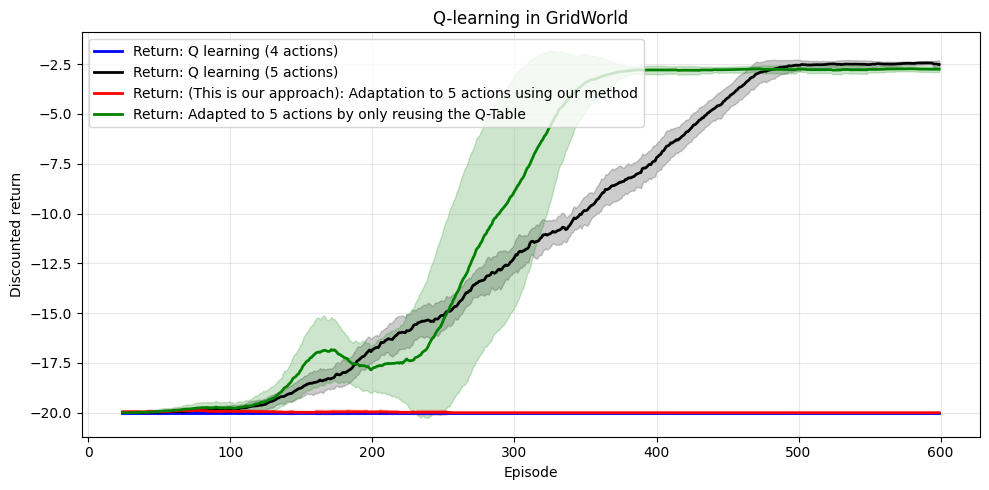

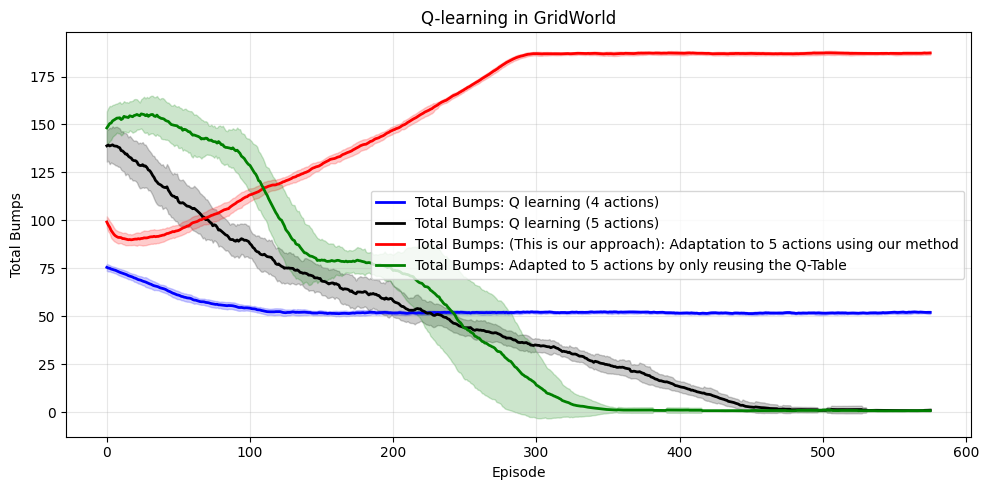

In [9]:
import copy
def run_multiple_experiments(n_runs=5, base_seed=123):
    """Run multiple experiments with different seeds and return statistics"""
    
    # Storage for all runs
    all_returns4 = []
    all_returns5plain = []
    all_returns5oracle = []
    all_returns5ignore = []
    all_bumps4 = []
    all_bumps5plain = []
    all_bumps5oracle = []
    all_bumps5ignore = []
    
    for run in range(n_runs):
        current_seed = base_seed + run * 42
        # Reset random seeds
        rng = np.random.default_rng(current_seed)
        random.seed(current_seed)
        np.random.seed(current_seed)
        
        # 1. Q-learning with 4 actions
        agent_plain_4_action = QLearningAgent(grid_world, 4, seed=current_seed)
        agent_plain_4_action.train(ACTIONS_4, epsilon_greedy, BUMP_REWARD)
        results_plain = agent_plain_4_action.get_results(moving_average)
        all_returns4.append(results_plain['returns'])
        all_bumps4.append(results_plain['bumps'])
         # 4. Oracle Q-learning with 5 actions
        oracle_agent_run = OracleQLearningAgent(grid_world, 5, base_q_table=copy.deepcopy(agent_plain_4_action.Q), seed=current_seed, use_model=False, use_conditional=True)
        oracle_agent_run.train_with_oracle(ACTIONS_5, epsilon_greedy, BUMP_REWARD, oracle_model, copy.deepcopy(agent_plain_4_action.Q))
        oracle_results_run = oracle_agent_run.get_results(moving_average)
        all_returns5oracle.append(oracle_results_run['returns'])
        all_bumps5oracle.append(oracle_results_run['bumps'])
         # 3. Ignore model (only Q-table reuse)
        ignore_model_run = OracleQLearningAgent(grid_world, 5, base_q_table=copy.deepcopy(agent_plain_4_action.Q), seed=current_seed, use_model=True, use_conditional=False)
        ignore_model_run.train_with_oracle(ACTIONS_5, epsilon_greedy, BUMP_REWARD, oracle_model, copy.deepcopy(agent_plain_4_action.Q))
        ignore_model_result_run = ignore_model_run.get_results(moving_average)
        all_returns5ignore.append(ignore_model_result_run['returns'])
        all_bumps5ignore.append(ignore_model_result_run['bumps'])
        # 2. Plain Q-learning with 5 actions
        agent_plain = QLearningAgent(grid_world, 5, seed=current_seed)
        agent_plain.train(ACTIONS_5, epsilon_greedy, BUMP_REWARD)
        results_plain = agent_plain.get_results(moving_average)
        all_returns5plain.append(results_plain['returns'])
        all_bumps5plain.append(results_plain['bumps'])
    
    # Calculate statistics
    all_returns4 = np.array(all_returns4)
    all_returns5plain = np.array(all_returns5plain)
    all_returns5oracle = np.array(all_returns5oracle)
    all_returns5ignore = np.array(all_returns5ignore)
    all_bumps4 = np.array(all_bumps4)
    all_bumps5plain = np.array(all_bumps5plain)
    all_bumps5oracle = np.array(all_bumps5oracle)
    all_bumps5ignore = np.array(all_bumps5ignore)
    
    # Calculate moving averages for all runs
    ma_w = 25
    all_ret_ma4 = np.array([moving_average(returns, w=ma_w) for returns in all_returns4])
    all_ret_ma5plain = np.array([moving_average(returns, w=ma_w) for returns in all_returns5plain])
    all_ret_ma5oracle = np.array([moving_average(returns, w=ma_w) for returns in all_returns5oracle])
    all_ret_ma5ignore = np.array([moving_average(returns, w=ma_w) for returns in all_returns5ignore])
    
    all_bumps4_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps4])
    all_bumps5plain_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5plain])
    all_bumps5oracle_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5oracle])
    all_bumps5ignore_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5ignore])
    
    return {
        'returns': {
            '4_actions': {'mean': np.mean(all_ret_ma4, axis=0), 'std': np.std(all_ret_ma4, axis=0)},
            '5_plain': {'mean': np.mean(all_ret_ma5plain, axis=0), 'std': np.std(all_ret_ma5plain, axis=0)},
            '5_oracle': {'mean': np.mean(all_ret_ma5oracle, axis=0), 'std': np.std(all_ret_ma5oracle, axis=0)},
            '5_ignore': {'mean': np.mean(all_ret_ma5ignore, axis=0), 'std': np.std(all_ret_ma5ignore, axis=0)}
        },
        'bumps': {
            '4_actions': {'mean': np.mean(all_bumps4_avg, axis=0), 'std': np.std(all_bumps4_avg, axis=0)},
            '5_plain': {'mean': np.mean(all_bumps5plain_avg, axis=0), 'std': np.std(all_bumps5plain_avg, axis=0)},
            '5_oracle': {'mean': np.mean(all_bumps5oracle_avg, axis=0), 'std': np.std(all_bumps5oracle_avg, axis=0)},
            '5_ignore': {'mean': np.mean(all_bumps5ignore_avg, axis=0), 'std': np.std(all_bumps5ignore_avg, axis=0)}
        }
    }

# Run multiple experiments
print("Running multiple experiments for statistical analysis...")
stats = run_multiple_experiments(n_runs=30)

# Plot results with shaded error bars
def plot_with_shaded_errors(stats, figsize=(10, 5)):
    """Plot results with shaded error bars"""
    
    # Returns plot
    plt.figure(figsize=figsize)
    
    # Calculate x-axis for each series (they might have different lengths due to moving average)
    episodes_total = EPISODES
    ma_w = 25
    
    # Plot each method with shaded error bars
    methods = [
        ('4_actions', 'Q learning (4 actions)', 'blue'),
        ('5_plain', 'Q learning (5 actions)', 'black'), 
        ('5_oracle', '(This is our approach): Adaptation to 5 actions using our method', 'red'),
        ('5_ignore', 'Adapted to 5 actions by only reusing the Q-Table', 'green')
    ]
    
    for method_key, label, color in methods:
        mean_vals = stats['returns'][method_key]['mean']
        std_vals = stats['returns'][method_key]['std']
        x_vals = np.arange(episodes_total - len(mean_vals), episodes_total)
        
        # Plot mean line
        plt.plot(x_vals, mean_vals, color=color, label=f'Return: {label}', linewidth=2)
        
        # Plot shaded error region (mean ± std)
        plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                        color=color, alpha=0.2)
    
    plt.xlabel('Episode')
    plt.ylabel('Discounted return')
    plt.title('Q-learning in GridWorld')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Bumps plot
    plt.figure(figsize=figsize)
    
    for method_key, label, color in methods:
        mean_vals = stats['bumps'][method_key]['mean']
        std_vals = stats['bumps'][method_key]['std']
        x_vals = np.arange(len(mean_vals))
        
        # Plot mean line
        plt.plot(x_vals, mean_vals, color=color, label=f'Total Bumps: {label}', linewidth=2)
        
        # Plot shaded error region (mean ± std)
        plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                        color=color, alpha=0.2)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Bumps')
    plt.title('Q-learning in GridWorld')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the results with shaded error bars
plot_with_shaded_errors(stats)